In [6]:
# External Libraries
import skimage.io
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from IPython.display import clear_output

# Builtin libraries
import os
import math
import json
import time
import pathlib
import zipfile
import itertools
import functools
import collections
import concurrent.futures
from pprint import pprint
from threading import RLock

DB_PATH = "../DataScraping/data/pokemon_sprites_bulbapedia/"

# Nonogramize the image using skimage and np
- Use Kmeans to reduce number of palletes to essential colors, then replace old color with nearest colors from the new pallete
- Create nonogram array for each number of palletes (3, 5, 7) and then save.

In [7]:
def reduce_color_palette(im, n_colors=8, n_init=256, max_iter=500, tol=0.00001):
    """
    Reduce color palette using K-means
    n_colors: number of colors in the final image
    """
    im = np.copy(im)
    # Transform image to array
    w,h,z = im.shape
    im = im.reshape(w*h,z)
    
    # Train model
    kmeans = KMeans(n_clusters=n_colors, 
                    n_init=n_init, 
                    max_iter=max_iter, 
                    tol=tol,
                    random_state=0,
                   ).fit(im)
    
    # find out which cluster each pixel belongs to.
    labels = kmeans.predict(im)
    
    # the cluster centroids is our color palette
    identified_palette = np.array(kmeans.cluster_centers_).astype(int)
    
    # recolor the entire image
    recolored_img = np.copy(im)
    for index in range(len(im)):
        im[index] = identified_palette[labels[index]]
    
    # reshape for display
    im = im.reshape(w,h,z)
    
    return im

def get_colored_pixel_rectangle(im):
    """
    return First Row, Last Row, First Column, Last Column as a tuple
    """
    f_row = l_row = f_col = l_col = None
    for r, row in enumerate(im):
        for c, p in enumerate(row):
            pixel = "#" + "".join(f"{c:02x}" for c in p)
            if pixel[1:6:2] == "fff": continue
            if pixel[1:6:2] == "000": continue
            if f_row is None: f_row = r
            l_row = r
            if f_col is None or c < f_col: f_col = c
            if l_col is None or c > l_col: l_col = c
    return (f_row, l_row, f_col, l_col)

def get_row_counts(im):
    """
    return the groupby() of rows as dictionary
    """
    rows_count = {}
    for r in range(len(im)):
        count = []
        row = ["#" + "".join(f"{c:02x}" for c in p) for p in im[r,:]]
        for k, grp in itertools.groupby(row):
            count.append((k, len(list(grp))))
        rows_count[r] = count

    for k, count in rows_count.items():
        rows_count[k] = list(filter(lambda x:x[0][1:6:2] not in ("fff", "000"), 
                                    count))
    return rows_count

def get_col_counts(im):
    """
    return the groupby() of cols as dictionary
    """
    cols_count = {}
    for c in range(len(im[0,:])):
        count = []
        col = ["#" + "".join(f"{c:02x}" for c in p) for p in im[:,c]]
        for k, grp in itertools.groupby(col):
            count.append((k, len(list(grp))))
        cols_count[c] = count

    for k, count in cols_count.items():
        cols_count[k] = list(filter(lambda x:x[0][1:6:2] not in ("fff", "000"), 
                                    count,))
    return cols_count

def generate_nonogram_by_size(image_path, verbose=False):
    """
    Creating nonogram for 1 image
    """
    image = skimage.io.imread(image_path)[:,:,:-1] # to Exclude alpha
    image = crop_image(image)
    nonogram_by_ncolor = {}
    for n_color in (3, 5, 7):
        im = reduce_color_palette(image, n_colors=n_color, n_init=256, max_iter=500, tol=1e-05)
        rows_count = get_row_counts(im)
        cols_count = get_col_counts(im)
        nonogram_by_ncolor[n_color] = [rows_count, cols_count]
    
#     with lock:
#         nonogram[image_path.rsplit("/",1)[-1]]=nonogram_by_ncolor
    if verbose:
        print(f"Done with {image_path}")
    return nonogram_by_ncolor

def crop_image(im):
    """
    Crop empty rows and columns
    """
    (f_row, l_row, f_col, l_col) = get_colored_pixel_rectangle(im)
    return im[f_row:l_row+1, f_col:l_col+1]

# WIP
def multithread(image_paths=[], no_threads=16, verbose=False):
    """
    Multithreading creating nonogram
    """
    nonogram = {}
    lock = RLock()
    with concurrent.futures.ThreadPoolExecutor(max_workers=no_threads) as executor:
        partial_func = functools.partial(generate_nonogram_by_size, nonogram=nonogram, lock=lock, verbose=verbose)
        executor.map(partial_func, image_paths)
    return nonogram


## Create Nonogram (Test Run)

Original Image


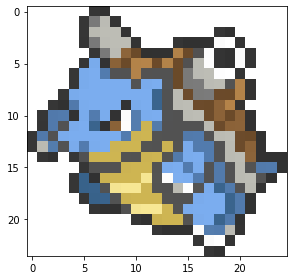

Image with 2 color pallettes (Not including white)


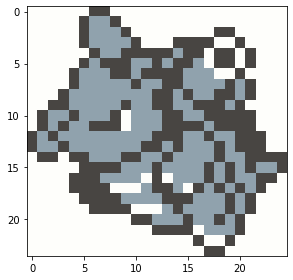

Image with 4 color pallettes (Not including white)


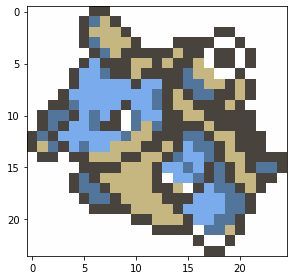

Image with 6 color pallettes (Not including white)


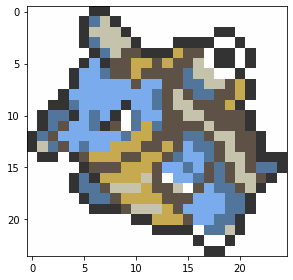

In [8]:
im = skimage.io.imread("../DataScraping/data/pokemon_sprites_bulbapedia/009_Blastoise.png")
im = crop_image(im)
print("Original Image")
skimage.io.imshow(im)
skimage.io.show()
for no in 3, 5, 7:
    print(f"Image with {no - 1} color pallettes (Not including white)")
    im1 = reduce_color_palette(im[:,:,:-1], no) # im[:,:,:-1] to Exclude alpha
    skimage.io.imshow(im1)
    skimage.io.show()
# generate_nonogram_by_size("../DataScraping/data/pokemon_sprites_bulbapedia/009_Blastoise.png")


## Create Nonogram (Actual Run)

In [78]:
nonogram = {}
for i, file in enumerate(os.listdir(DB_PATH)):
    if i % 10 == 0: clear_output()
    nonogram_by_ncolor = generate_nonogram_by_size(DB_PATH + file, True)
    nonogram[file] = nonogram_by_ncolor
print(f"Finish nonogramize all sprites")

Done with ../DataScraping/data/pokemon_sprites_bulbapedia/001_Bulbasaur.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/002_Ivysaur.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/003_Venusaur.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/004_Charmander.png


KeyboardInterrupt: 

In [50]:
with open("./data/nonogram_bulbapedia.json", "w") as f:
    json.dump(nonogram, f)

# Export Pokemon images with new palletes

In [11]:
def convert_color_to_string(im):
    """
    Convert color from numpy array to format #ffffff
    """
    new_im = []
    for r, row in enumerate(im):
        cur = []
        for c, p in enumerate(row):
            pixel = "#" + "".join(f"{c:02x}" for c in p)
            if pixel[1:6:2] == "fff": pixel = "w"
            if pixel[1:6:2] == "000": pixel = "b"
            cur.append(pixel)
        new_im.append(cur)
    
        
    return new_im

def group_colors(im_str):
    """
    Return the group by of rows as dictionary (including white and black)
    """
    rows_count = {}
    for r, row in enumerate(im_str):
        count = []
        for k, grp in itertools.groupby(row):
            count.append((k, len(list(grp))))
        rows_count[r] = count
    return rows_count

def convert_images_to_string(image_path, verbose=False):
    """
    For each reduces pallete, convert image to string
    """
    image = skimage.io.imread(image_path)[:,:,:-1] # to Exclude alpha
    image = crop_image(image)
    image_str_by_ncolor = {}
    image_str_by_ncolor["SIZE"] = (len(image), len(image[0,:]))
    for n_colors in (3, 5, 7):
        im = reduce_color_palette(image, n_colors) # im[:,:,:-1] to Exclude alpha
        im_str = convert_color_to_string(im)
        rows_count = group_colors(im_str)
        image_str_by_ncolor[n_colors] = rows_count
        
    if verbose:
        print(f"Done with {image_path}")
    return image_str_by_ncolor

image_str_by_pokemon = {}
for i, file in enumerate(os.listdir(DB_PATH)):
    if i and i % 10 == 0: clear_output()
    image_str_by_ncolor = convert_images_to_string(DB_PATH + file, True)
    image_str_by_pokemon[file] = image_str_by_ncolor
print(f"Finish all sprites")

Done with ../DataScraping/data/pokemon_sprites_bulbapedia/892_1_Urshifu.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/892_Urshifu.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/893_Zarude.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/894_Regieleki.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/895_Regidrago.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/896_Glastrier.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/897_Spectrier.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/898_1_Calyrex.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/898_2_Calyrex.png
Done with ../DataScraping/data/pokemon_sprites_bulbapedia/898_Calyrex.png
Finish all sprites


In [12]:
with open("./data/image_str_bulbapedia.json", "w") as f:
    json.dump(image_str_by_pokemon, f)

## nonogramize the image using PIL (old)

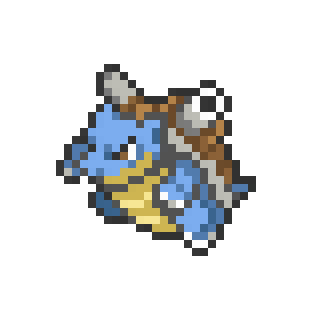

In [3]:
im = Image.open("../DataScraping/data/pokemon_sprites_bulbapedia/009_Blastoise.png")

im = im.convert("RGBA", palette=Image.ADAPTIVE, colors=256)
# im = im.convert('P', palette=Image.WEB, colors=12)
# im = im.convert('P', dither=Image.NONE, palette=Image.ADAPTIVE, colors=5)
# im = im.convert("RGBA", palette=Image.ADAPTIVE, colors=256)
pix = im.load()
W, H = im.size

# Resize to view
ratio = math.ceil(300/W)
im.resize([W * ratio, H * ratio], resample=Image.NEAREST)

#### Find start and end row/col

In [3]:
# First and Last Row/Column
f_row = l_row = f_col = l_col = None
for y in range(H):
    for x in range(W):
        if pix[x, y] == (255, 255, 255, 0): continue
        if not f_row: f_row = y
        l_row = y
        if not f_col or x < f_col: f_col = x
        if not l_col or x > l_col: l_col = x
print(f_row, l_row, f_col, l_col)

8 31 7 31


In [4]:
# Count color freq
rows_count = {}
for y in range(f_row, l_row + 1):
    count = []
    row = []
    for x in range(f_col, l_col + 1):
        p = pix[x, y]
        row.append("#%02x%02x%02x%02x"%(p[0], p[1], p[2], p[3]))
    for k, grp in itertools.groupby(row):
        count.append((k, len(list(grp))))
    rows_count[y] = count
    
for k, count in rows_count.items():
    rows_count[k] = list(filter(lambda x: x[0] != "#ffffff00", count))
# pprint(rows_count, compact=True)